<a href="https://colab.research.google.com/github/priyanshusankhala/hasoc-hnlp/blob/main/En_SubtaskA_xlnet_cased_experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#This code is adapted from hindi v2

In [ ]:
cd /content/drive/MyDrive/HASOC/

/content/drive/MyDrive/HASOC


In [ ]:
ls

Analysis/            Data/   predictionstrue.txt  __pycache__/
Bert-large-cased-0/  model/  predictions.txt      task1_baseline.py


In [ ]:
! pip install transformers
! pip install neptune-client

train0

In [ ]:
###############################################################

# baseline code for task 1
# using BERT-based classification
# With the exception of the evaluation part 
# (which reflects the tasks evaluation code), 
# this code is taken from
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

###############################################################


import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import XLNetTokenizer, XLNetModel
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os
import os.path
from sklearn import metrics
import neptune
load_model = False
save_model = False

if load_model:
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin"
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin"
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin"


pre processing

In [ ]:
# Load the dataset into a pandas dataframe.
data = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_train.csv", delimiter=',')
# dev_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_train.csv", delimiter=',', header=None, names=['id', 'sentence', 'label', 'alpha'])


In [ ]:
data.head()

,Unnamed: 0,_id,text,task_1,task_2
0,4986,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,HOF,PRFN
1,3394,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,HOF,OFFN
2,1310,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT,NONE
3,3390,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF,OFFN
4,4626,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,HOF,OFFN


In [ ]:
data.task_1.value_counts(normalize=True)

HOF    0.650794
NOT    0.349206
Name: task_1, dtype: float64

In [ ]:
data.task_1 = data.task_1.str.replace('NOT','0')
data.task_1 = data.task_1.str.replace('HOF','1')
data.task_1 = data.task_1.astype(int)
data.task_2 = data.task_2.str.replace('PRFN','0')
data.task_2 = data.task_2.str.replace('OFFN','1')
data.task_2 = data.task_2.str.replace('NONE','2')
data.task_2 = data.task_2.str.replace('HATE','3')
data.task_2 = data.task_2.astype(int)
df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

In [ ]:
df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

In [ ]:
df.head()

,Unnamed: 0,_id,text,task_1,task_2
1358,4990,60c5d6bf5659ea5e55def71a,Let country ðŸ‡®ðŸ‡³ image go to hell but gove...,0,2
2200,4028,60c5d6bf5659ea5e55defac1,In India's days of darkest despair we are seei...,1,3
2337,2380,60c5d6bf5659ea5e55df01ee,i want to bite a dick,1,0
3640,283,60c5d6bf5659ea5e55def483,There is only one centre where vaccination for...,0,2
2928,1636,60c5d6bf5659ea5e55defb38,just want the swagger of that one asshole drum...,1,0


In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))


Number of training sentences: 3,074



In [ ]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.task_1.values
labels

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
# Get the lists of sentences and their labels.
dev_sentences = dev_df.text.values
dev_labels = dev_df.task_1.values

In [ ]:
# print(tokenizer.pad_token_id)

train 1

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
if load_model:
    tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased", do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-cased", do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain", do_lower_case = True)
    #tokenizer = BertTokenizer.from_pretrained(output_vocab_file, do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-DistilBert-Class")
    #tokenizer = BertTokenizer.from_pretrained('verloop/Hinglish-DistilBert-Class', do_lower_case = False)
else:
    tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased", do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-cased", do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain", do_lower_case = True)
    #tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-DistilBert-Class")
    #tokenizer = BertTokenizer.from_pretrained('verloop/Hinglish-DistilBert-Class', do_lower_case=False)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
dev_input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# For every sentence...
for sent in dev_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    dev_input_ids.append(encoded_sent)

Loading BERT tokenizer...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
l = [len(x) for x in input_ids]

In [ ]:
np.quantile(l, 0.98)

114.0

(array([1.142e+03, 1.428e+03, 4.690e+02, 3.300e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  4. ,  43.9,  83.8, 123.7, 163.6, 203.5, 243.4, 283.3, 323.2,
        363.1, 403. ]),
 <a list of 10 Patch objects>)

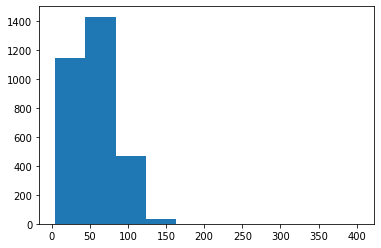

In [ ]:
np.histogram(l)
plt.hist(l)

In [ ]:
import matplotlib.pyplot as plt
# plt.scatter(data.task_1['_id'], data.task_1['labels'])
# plt.show() # Depending on whether you use IPython or interactive mode, etc.
# plt.plot(train_loss)

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 120

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
pad_token = tokenizer.pad_token_id

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=pad_token, truncating="post", padding="post")

dev_input_ids = pad_sequences(dev_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=pad_token, truncating="post", padding="post")

print('\nDone.')


# Create attention masks
attention_masks = []
dev_attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id != pad_token) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# For each sentence...
for sent in dev_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id != pad_token) for token_id in sent]

    
    # Store the attention mask for this sentence.
    dev_attention_masks.append(att_mask)
    

# Use 90% for training and 10% for validation.
train_inputs = input_ids 
validation_inputs = dev_input_ids
train_labels = labels
validation_labels = dev_labels

# Do the same for the masks.
train_masks =  attention_masks
validation_masks = dev_attention_masks
                                             
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


Padding/truncating all sentences to 120 values...

Padding token: "<pad>", ID: 5

Done.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased",output_attentions = False,output_hidden_states = False)
# model.layer_1 = nn.Linear(768,2)
# model.layer_2 = nn.Linear(3072,2)
# model.classifier = nn.Linear(768,2)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
# if load_model:
# # Load BertForSequenceClassification, the pretrained BERT model with a single 
# # linear classification layer on top.
#     config = BertConfig.from_json_file(output_config_file)
#     model = BertForSequenceClassification(config)
#     state_dict = torch.load(output_model_file)
#     model.load_state_dict(state_dict)

# else: 
#     model = BertForSequenceClassification.from_pretrained(
#         "xlnet-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
#         num_labels = 2, # The number of output labels--2 for binary classification.
#                         # You can increase this for multi-class tasks.   
#         output_attentions = False, # Whether the model returns attentions weights.
#         output_hidden_states = False, # Whether the model returns all hidden-states.
#     )

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain",  output_attentions = False,output_hidden_states = False)
# model.classifier = nn.Linear(768,2)

In [ ]:

model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", output_attentions = False,output_hidden_states = False)
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model

XLNetLMHeadModel(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
import torch

#tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
#model = XLNetModel.from_pretrained('xlnet-base-cased')
model.layer_1 = nn.Linear(768,2)
model.layer_2 = nn.Linear(3072,2)
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state

In [ ]:
outputs[0]

tensor([[ 1.5312e-01, -4.3372e-01],
        [-3.5174e-01, -1.4604e-01],
        [ 4.0887e-01,  5.0182e-02],
        [-1.4642e-01, -2.3870e-01],
        [-3.5147e-02, -3.1096e-04],
        [ 5.6569e-02, -4.5840e-01],
        [ 7.0638e-02, -7.4582e-01],
        [-5.1724e-01, -3.8599e-01]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.cuda()
print(device)


# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
learning_rate = 2e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
use_neptune = 1                                            
if use_neptune:
    api = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDRkYTliMS1lZGRjLTRhOWMtOGU0ZC04OTEzNzU1Y2E2Y2MifQ=="
    neptune.init(project_qualified_name='hnlp.hasoc/nlp', api_token=api)
    PARAMS = {'lr': learning_rate,}
    tags = ['bert']
    neptune.create_experiment("First_exp", tags=tags, params=PARAMS)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([2/3,1/3]).to(device))
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    #new
    train_loss = []
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        #logits = outputs[pad_token
        #logits = outputs[num_predict]
        #logits = nn.classifier(mean_last_hidden_state)
        #logits = logits[:, 1] - logits[:, 0]
        logits = outputs[0]
        loss = criterion(logits,b_labels)
        #loss = outputs.loss
        #logits = outputs.logits  # Logits have shape [target_mapping.size(0), target_mapping.size(1), config.vocab_size]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        neptune.log_metric("Loss_Train",loss.item())
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        #new
        train_loss.append(loss.item())
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    #print("  training loss: {0:.2f}".format(train_loss))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    predictions , true_labels = [], []

    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        ##
        predictions.append(logits)
        true_labels.append(label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    
        # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

        # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]
        
    def evaluate(y_true, y_pred):
    
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')
        # Evaluate predictions    
    evaluate(flat_true_labels, flat_predictions)
    # Calculate the accuracy for this batch of test sentences.
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
    def func_call_test(epoch_id):
      #test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',') #, header=None, names=['id', 'sentence', 'label']
      test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',', header=None, names=['id', 'sentence', 'label'])
      # data.task_1 = data.task_1.str.replace('NOT','0')
      # data.task_1 = data.task_1.str.replace('HOF','1')
      # data.task_1 = data.task_1.astype(int)
      test_sentences = test_df.sentence.values
      test_labels = test_df.label.values
      # Report the number of sentences.
      print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
      # /Check This
      # Will this make sense now?
      # Since the files are no longer loading with the gives headers. Think about it and give the necessary loading names
      # /
      # /test_sentences = test_df.sentence.values ##
      # /test_labels = test_df.label.values
      # / UNcomment/delete after done
      # Tokenize all of the sentences and map the tokens to thier word IDs.
      test_input_ids = []

      # For every sentence...
      for sent in test_sentences:
          # `encode` will:
          #   (1) Tokenize the sentence.
          #   (2) Prepend the `[CLS]` token to the start.
          #   (3) Append the `[SEP]` token to the end.
          #   (4) Map tokens to their IDs.
          encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
          
          test_input_ids.append(encoded_sent)

      # Pad our input tokens
      test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                                dtype="long", truncating="post", padding="post")

      # Create attention masks
      test_attention_masks = []

      # Create a mask of 1s for each token followed by 0s for padding
      for seq in test_input_ids:
        seq_mask = [int(i != pad_token) for i in seq]
        #seq_mask = [int(i!= pad_token) for i in seq]
        #seq_mask = [float(i>0) for i in seq]
        test_attention_masks.append(seq_mask) 

      # Convert to tensors.
      prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
      prediction_masks = torch.tensor(test_attention_masks)
      prediction_labels = torch.tensor(test_labels).to(torch.int64)

      # Set the batch size.  
      batch_size = 8  

      # Create the DataLoader.
      prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
      prediction_sampler = SequentialSampler(prediction_data)
      prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

      # Prediction on test set

      print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

      # Put model in evaluation mode
      model.eval()

      # Tracking variables 
      predictions , true_labels = [], []
    
      # Predict 
      for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

      print('    DONE.')

      print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
      with open('/content/drive/MyDrive/HASOC/Data/predictionstrue_en_xlnet.csv', "w") as writer:
          for i,line in enumerate(predictions):
              writer.write(str(line) +" " +str(true_labels[i]) + "\n")
        
      # Combine the predictions for each batch into a single list of 0s and 1s.
      flat_predictions = [item for sublist in predictions for item in sublist]
      flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

      # Combine the correct labels for each batch into a single list.
      flat_true_labels = [item for sublist in true_labels for item in sublist]

      def evaluate(y_true, y_pred):
          """
          Evaluate Precision, Recall, F1 scores between y_true and y_pred
          If output_file is provided, scores are saved in this file otherwise printed to std output.
          :param y_true: true labels
          :param y_pred: predicted labels
          :return: list of scores (F1, Recall, Precision, ExactMatch)
          """
          
          assert len(y_true) == len(y_pred)
          precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
          scores = [
              "F1: %f\n" % f1,
              "Recall: %f\n" % recall,
              "Precision: %f\n" % precision,
              "ExactMatch: %f\n" % -1.0
          ]
          for s in scores:
              print(s, end='')

      # Evaluate predictions    
      evaluate(flat_true_labels, flat_predictions)

      print('Writing predictions to file...')
      with open("/content/drive/MyDrive/HASOC/Data/statout_en_xlnet"+str(epoch_i)+".csv", "w") as writer:
        for line in flat_predictions:
              writer.write(str(line) + "\n")
      #//Check this    
     # Save predictions to file
      with open('/content/drive/MyDrive/HASOC/Data/predictions_xlnet.csv', "w") as writer:
          for line in flat_predictions:
              writer.write(str(line) + "\n")
              
      print('Done writing predictions...')


      if(save_model):
          v = 0
          folder_name = "Bert-large-cased-" + str(v)
          if(os.path.exists(folder_name)):
              v+=1
              folder_name = "Bert-large-uncased-" + str(v)
          else:
              os.mkdir(folder_name)

          # output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
          # output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
          # output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)
          output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_hifile.bin".format(model)
          output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_hifile.bin".format(model)
          output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_hifile.bin".format(model)

          # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

          # If we have a distributed model, save only the encapsulated model
          # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
          model_to_save = model.module if hasattr(model, 'module') else model

          torch.save(model_to_save.state_dict(), output_model_file)
          model_to_save.config.to_json_file(output_config_file)
          tokenizer.save_vocabulary(output_vocab_file)

    func_call_test(epoch_i)
print("")
print("Training complete!")

# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.

cuda
The BERT model has 210 different named parameters.

==== Embedding Layer ====

transformer.mask_emb                                     (1, 1, 768)
transformer.word_embedding.weight                       (32000, 768)
transformer.layer.0.rel_attn.q                          (768, 12, 64)
transformer.layer.0.rel_attn.k                          (768, 12, 64)
transformer.layer.0.rel_attn.v                          (768, 12, 64)

==== First Transformer ====

transformer.layer.0.rel_attn.o                          (768, 12, 64)
transformer.layer.0.rel_attn.r                          (768, 12, 64)
transformer.layer.0.rel_attn.r_r_bias                       (12, 64)
transformer.layer.0.rel_attn.r_s_bias                       (12, 64)
transformer.layer.0.rel_attn.r_w_bias                       (12, 64)
transformer.layer.0.rel_attn.seg_embed                   (2, 12, 64)
transformer.layer.0.rel_attn.layer_norm.weight                (768,)
transformer.layer.0.rel_attn.layer_norm.bias         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    385.    Elapsed: 0:00:20.
  Batch    80  of    385.    Elapsed: 0:00:41.
  Batch   120  of    385.    Elapsed: 0:01:01.
  Batch   160  of    385.    Elapsed: 0:01:21.
  Batch   200  of    385.    Elapsed: 0:01:42.
  Batch   240  of    385.    Elapsed: 0:02:02.
  Batch   280  of    385.    Elapsed: 0:02:22.
  Batch   320  of    385.    Elapsed: 0:02:43.
  Batch   360  of    385.    Elapsed: 0:03:03.

  Average training loss: 0.46
  Training epcoh took: 0:03:15

Running Validation...
F1: 0.795563
Recall: 0.793238
Precision: 0.800502
ExactMatch: -1.000000
  Accuracy: 0.79
  Validation took: 0:00:17
Number of test sentences: 1,282

Predicting labels for 1,282 test sentences...
    DONE.
Positive samples: 0 of 1282 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writi

In [ ]:
import torch
#torch.cuda.empty_cache()
import gc
#del variables
# gc.collect()


**Ignore **

In [ ]:
# import gc
# del variables
# gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   10752 MB |   10752 MB |   14424 MB |    3672 MB |\n|       from large pool |   10602 MB |   10602 MB |   14273 MB |    3670 MB |\n|       from small pool |     149 MB |     149 MB |     151 MB |       1 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   10752 MB |   10752 MB |   14424 MB |    3672 MB |\n|       from large pool |   10602 MB |   10602 MB |

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_train.csv", delimiter=',')

In [ ]:

# data.task_1 = data.task_1.str.replace('NOT','0')
# data.task_1 = data.task_1.str.replace('HOF','1')
# data.task_1 = data.task_1.astype(int)
data.task_1.value_counts(normalize=True)

SyntaxError: ignored

In [ ]:
import pandas as pd
df3 = pd.read_csv("/content/drive/MyDrive/HASOC/Data/statout_en_v32.csv", delimiter=',')
#df3.head()

# df3 = df3.iloc[: , 1:]
#len(df3)
df3.replace(0, 'NOT', inplace=True)  # for replacing nan to 0
df3.replace(1, 'HOF', inplace=True)  # for replacing nan to 0
df3.head()

# df3 = df3.str.replace('0','NOT')
# df3 = df3.str.replace('1', 'HOF')
# df3 = df3.astype(int)

,0
0,NOT
1,HOF
2,HOF
3,HOF
4,NOT


In [ ]:
df3.to_csv("/content/drive/MyDrive/HASOC/Data/en_second_run_3.csv", index=False)

In [ ]:
# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.
test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',')
test_df.head()

In [ ]:
test_df["labels"] = None

### New section large


In [ ]:
###############################################################

# baseline code for task 1
# using BERT-based classification
# With the exception of the evaluation part 
# (which reflects the tasks evaluation code), 
# this code is taken from
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

###############################################################


import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os
import os.path
from sklearn import metrics
import neptune
load_model = False
save_model = False

if load_model:
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin"
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin"
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin"


In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
if load_model:
    tokenizer = AutoTokenizer.from_pretrained("bert-large-cased")
    
    #tokenizer = BertTokenizer.from_pretrained(output_vocab_file, do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-DistilBert-Class")
    #tokenizer = BertTokenizer.from_pretrained('verloop/Hinglish-DistilBert-Class', do_lower_case = False)
else:
    tokenizer = AutoTokenizer.from_pretrained("bert-large-cased", do_lower_case = False)
    
    #tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-DistilBert-Class")
    #tokenizer = BertTokenizer.from_pretrained('verloop/Hinglish-DistilBert-Class', do_lower_case=False)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
dev_input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# For every sentence...
for sent in dev_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    dev_input_ids.append(encoded_sent)

Loading BERT tokenizer...


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 120

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

dev_input_ids = pad_sequences(dev_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []
dev_attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# For each sentence...
for sent in dev_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    dev_attention_masks.append(att_mask)
    

# Use 90% for training and 10% for validation.
train_inputs = input_ids 
validation_inputs = dev_input_ids
train_labels = labels
validation_labels = dev_labels

# Do the same for the masks.
train_masks =  attention_masks
validation_masks = dev_attention_masks
                                             
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 4

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


Padding/truncating all sentences to 120 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain",  output_attentions = False,output_hidden_states = False)
model = AutoModelForMaskedLM.from_pretrained("bert-large-cased",  output_attentions = False,output_hidden_states = False)


Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
if load_model:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.
    #config = BertConfig.from_json_file(output_config_file)
    #model = BertForSequenceClassification(config)
    #state_dict = torch.load(output_model_file)
    #model.load_state_dict(state_dict)
    model = AutoModelForMaskedLM.from_pretrained("bert-large-cased",num_labels = 2,  output_attentions = False,output_hidden_states = False)
    state_dict = torch.load(output_model_file)
    model.load_state_dict(state_dict)
else: 
    model = AutoModelForMaskedLM.from_pretrained("bert-large-cased",num_labels = 2,  output_attentions = False,output_hidden_states = False)
    # model = BertForSequenceClassification.from_pretrained(
    #     "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
    #     num_labels = 2, # The number of output labels--2 for binary classification.
    #                     # You can increase this for multi-class tasks.   
    #     output_attentions = False, # Whether the model returns attentions weights.
    #     output_hidden_states = False, # Whether the model returns all hidden-states.
    # )


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.cuda()
print(device)


# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
learning_rate = 2e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
use_neptune = 1                                            
if use_neptune:
    api = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDRkYTliMS1lZGRjLTRhOWMtOGU0ZC04OTEzNzU1Y2E2Y2MifQ=="
    neptune.init(project_qualified_name='hnlp.hasoc/nlp', api_token=api)
    PARAMS = {'lr': learning_rate,}
    tags = ['bert']
    neptune.create_experiment("First_exp", tags=tags, params=PARAMS)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([2/3,1/3]).to(device))
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    #new
    train_loss = []
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        logits = outputs[0]
        loss = criterion(logits,b_labels)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        neptune.log_metric("Loss_Train",loss.item())
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        #new
        train_loss.append(loss.item())
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    #print("  training loss: {0:.2f}".format(train_loss))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    predictions , true_labels = [], []

    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        ##
        predictions.append(logits)
        true_labels.append(label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    
        # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

        # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]
        
    def evaluate(y_true, y_pred):
    
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')
        # Evaluate predictions    
    evaluate(flat_true_labels, flat_predictions)
    # Calculate the accuracy for this batch of test sentences.
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
    def func_call_test(epoch_id):
      #test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',') #, header=None, names=['id', 'sentence', 'label']
      test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',', header=None, names=['id', 'sentence', 'label'])
      # data.task_1 = data.task_1.str.replace('NOT','0')
      # data.task_1 = data.task_1.str.replace('HOF','1')
      # data.task_1 = data.task_1.astype(int)
      test_sentences = test_df.sentence.values
      test_labels = test_df.label.values
      # Report the number of sentences.
      print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
      # /Check This
      # Will this make sense now?
      # Since the files are no longer loading with the gives headers. Think about it and give the necessary loading names
      # /
      # /test_sentences = test_df.sentence.values ##
      # /test_labels = test_df.label.values
      # / UNcomment/delete after done
      # Tokenize all of the sentences and map the tokens to thier word IDs.
      test_input_ids = []

      # For every sentence...
      for sent in test_sentences:
          # `encode` will:
          #   (1) Tokenize the sentence.
          #   (2) Prepend the `[CLS]` token to the start.
          #   (3) Append the `[SEP]` token to the end.
          #   (4) Map tokens to their IDs.
          encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
          
          test_input_ids.append(encoded_sent)

      # Pad our input tokens
      test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                                dtype="long", truncating="post", padding="post")

      # Create attention masks
      test_attention_masks = []

      # Create a mask of 1s for each token followed by 0s for padding
      for seq in test_input_ids:
        seq_mask = [int(token_id!= pad_token) for i in seq]
        #seq_mask = [float(i>0) for i in seq]
        test_attention_masks.append(seq_mask) 

      # Convert to tensors.
      prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
      prediction_masks = torch.tensor(test_attention_masks)
      prediction_labels = torch.tensor(test_labels).to(torch.int64)

      # Set the batch size.  
      batch_size = 8  

      # Create the DataLoader.
      prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
      prediction_sampler = SequentialSampler(prediction_data)
      prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

      # Prediction on test set

      print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

      # Put model in evaluation mode
      model.eval()

      # Tracking variables 
      predictions , true_labels = [], []
    
      # Predict 
      for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

      print('    DONE.')

      print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
      with open('/content/drive/MyDrive/HASOC/Data/predictionstrue_en_vbert_large.csv', "w") as writer:
          for i,line in enumerate(predictions):
              writer.write(str(line) +" " +str(true_labels[i]) + "\n")
        
      # Combine the predictions for each batch into a single list of 0s and 1s.
      flat_predictions = [item for sublist in predictions for item in sublist]
      flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

      # Combine the correct labels for each batch into a single list.
      flat_true_labels = [item for sublist in true_labels for item in sublist]

      def evaluate(y_true, y_pred):
          """
          Evaluate Precision, Recall, F1 scores between y_true and y_pred
          If output_file is provided, scores are saved in this file otherwise printed to std output.
          :param y_true: true labels
          :param y_pred: predicted labels
          :return: list of scores (F1, Recall, Precision, ExactMatch)
          """
          
          assert len(y_true) == len(y_pred)
          precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
          scores = [
              "F1: %f\n" % f1,
              "Recall: %f\n" % recall,
              "Precision: %f\n" % precision,
              "ExactMatch: %f\n" % -1.0
          ]
          for s in scores:
              print(s, end='')

      # Evaluate predictions    
      evaluate(flat_true_labels, flat_predictions)

      print('Writing predictions to file...')
      with open("/content/drive/MyDrive/HASOC/Data/statout_en_vbert_large"+str(epoch_i)+".csv", "w") as writer:
        for line in flat_predictions:
              writer.write(str(line) + "\n")
      #//Check this    
     # Save predictions to file
      with open('/content/drive/MyDrive/HASOC/Data/predictions_bert_large.csv', "w") as writer:
          for line in flat_predictions:
              writer.write(str(line) + "\n")
              
      print('Done writing predictions...')


      if(save_model):
          v = 0
          folder_name = "Bert-large-cased-" + str(v)
          if(os.path.exists(folder_name)):
              v+=1
              folder_name = "Bert-large-uncased-" + str(v)
          else:
              os.mkdir(folder_name)

          # output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
          # output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
          # output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)
          output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_hifile.bin".format(model)
          output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_hifile.bin".format(model)
          output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_hifile.bin".format(model)

          # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

          # If we have a distributed model, save only the encapsulated model
          # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
          model_to_save = model.module if hasattr(model, 'module') else model

          torch.save(model_to_save.state_dict(), output_model_file)
          model_to_save.config.to_json_file(output_config_file)
          tokenizer.save_vocabulary(output_vocab_file)

    func_call_test(epoch_i)
print("")
print("Training complete!")

# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.

cuda
The BERT model has 394 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias         

RuntimeError: ignored